# Exercise 4: Neural Networks Learning

In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we
provided for the neural network parameters. In this exercise, you will implement the backpropagation algorithm
to learn the parameters for the neural network.

As always, we start by importing the packages to use during the exercise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io #Load matlab files
import pandas as pd
import random
from scipy.optimize import fmin_ncg
from scipy.optimize import minimize

## Exercise 4, Part 1: Visualizing the data

This is the same dataset that you used in the previous exercise. There are
5000 training examples in ex3data1.mat, where each training example is a
20 pixel by 20 pixel grayscale image of the digit, and which is a subset  of the MNIST handwritten digit dataset (http://yann.lecun.com/exdb/mnist/).

Each pixel is represented by
a floating point number indicating the grayscale intensity at that location.
The 20 by 20 grid of pixels is unrolled into a 400-dimensional vector. Each
of these training examples becomes a single row in our data matrix $X$. This
gives us a 5000 by 400 matrix $X$ where every row is a training example for a
handwritten digit image.

The second part of the training set is a 5000-dimensional vector y that
contains labels for the training set.

We can inspect the dimension of X, which results on a real matrix with dimensions (m x n) = (5000, 400).
We are, however, interested on compressing the n dimension as a 20pixel x 20pixel information.


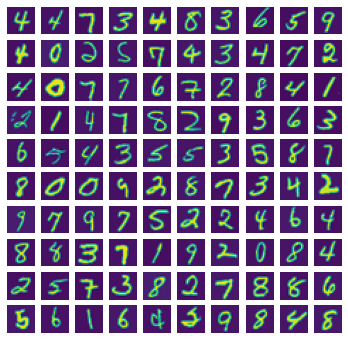

In [2]:
data = scipy.io.loadmat('data/ex4data1.mat')
X = data['X']
Y = data['y'].ravel()
K, counts = np.unique(Y,return_counts=True)

m, n = X.shape #Number of training examples, number of features

print(r"We can inspect the dimension of X, which results on a real matrix with dimensions (m x n) = "+str(X.shape)+".")
print("We are, however, interested on compressing the n dimension as a 20pixel x 20pixel information.")

Xshaped = np.zeros((5000,20,20),dtype=float)
idxlist = []
for i in range(5000):
    Xshaped[i,:,:] = X[i,:].reshape((20,20),order='F')
    idxlist.append(i)
    
# Randomly select 25 data points to display    
random.shuffle(idxlist)

#Display random data
fig, axes = plt.subplots(10,10, figsize=(6,6))
for i,ax in enumerate(axes.flat):
    ax.axis('off')
    ax.imshow(Xshaped[idxlist[i],:,:])

## Exercise 4, Part 2: Model Representation

Our neural network is shown in the following Figure. It has 3 layers an input layer,
a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20 × 20, this gives us 400 input
layer units (not counting the extra bias unit which always outputs +1). 


Our neural network is shown in the following Figure. It has 3 layers an input layer, a
hidden layer and an output layer. Recall that our inputs are pixel values of
digit images. Since the images are of size 20×20, this gives us 400 input layer
units (excluding the extra bias unit which always outputs +1). As before,
the training data will be loaded into the variables $X$ and $y$.

![image](images/NNmodel.png)


You have been provided with a set of network parameters ($\Theta$(1); $\Theta$(2))
already trained by us. These are stored in ex4weights.mat and are categorized as Theta1 and Theta2. The parameters have dimensions
that are sized for a neural network with 25 units in the second layer and 10
output units (corresponding to the 10 digit classes).

In [3]:
weights = scipy.io.loadmat('data/ex4weights.mat')
Theta1 = weights['Theta1'] #Shape = (25,401)unit is -- 400 from 20px*20px + 1 from bias unit
Theta2 = weights['Theta2'] #Shape (10,26) -- 25 + 1 from bias unit

print(Theta1.shape,Theta2.shape)

#Unrolling parameters
Theta_unrolled = np.concatenate((Theta1.flatten(),Theta2.flatten()))
print(Theta_unrolled.shape)

(25, 401) (10, 26)
(10285,)


## Exercise 4, Part 3: Feedforward and cost function

Now you will implement the cost function and gradient for the neural network. First, complete the code in **nnCostFunction** to return the cost. You can assume that the neural network will only have 3 layers { an input
layer, a hidden layer and an output layer. However, your code should work
for any number of input units, hidden units and outputs units. While we
have explicitly listed the indices above for Θ(1) and Θ(2) for clarity, do note
that your code should in general work with Θ(1) and Θ(2) of any size. Note that you should not be regularizing the terms that correspond to
the bias. For the matrices Theta1 and Theta2, this corresponds to the first
column of each matrix. 

Recall that the cost function for the neural network (without regularization) is

<center>
    $\begin{aligned} J(\theta)=& \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K}\left[-y_{k}^{(i)} \log \left(\left(h_{\theta}\left(x^{(i)}\right)\right)_{k}\right)-\left(1-y_{k}^{(i)}\right) \log \left(1-\left(h_{\theta}\left(x^{(i)}\right)\right)_{k}\right)\right]+\\ & \frac{\lambda}{2 m}\left[\sum_{j=1}^{25} \sum_{k=1}^{400}\left(\Theta_{j, k}^{(1)}\right)^{2}+\sum_{j=1}^{10} \sum_{k=1}^{25}\left(\Theta_{j, k}^{(2)}\right)^{2}\right] \end{aligned}$<center>
    
where hθ(x(i)) is computed as shown in the Figure 2 and K = 10 is the total
number of possible labels. Note that hθ(x(i))k = a(3) k is the activation (output
value) of the k-th output unit. Also, recall that whereas the original labels
(in the variable y) were 1, 2, ..., 10, for the purpose of training a neural
network, we need to recode the labels as vectors containing only values 0 or
1, so that
    
<center>
$y=\left[\begin{array}{c}1 \\ 0 \\ 0 \\ \vdots \\ 0\end{array}\right], \quad\left[\begin{array}{c}0 \\ 1 \\ 0 \\ \vdots \\ 0\end{array}\right], \quad \ldots \quad$ or $\quad\left[\begin{array}{c}0 \\ 0 \\ 0 \\ \vdots \\ 1\end{array}\right]$
<center>
    
For example, if x(i) is an image of the digit 5, then the corresponding
y(i) (that you should use with the cost function) should be a 10-dimensional
vector with y5 = 1, and the other elements equal to 0. You should implement the feedforward computation that computes hθ(x(i))
for every example i and sum the cost over all examples. Your code should
also work for a dataset of any size, with any number of labels (you
can assume that there are always at least K ≥ 3 labels). Once you are done, ex4.m will call your nnCostFunction using the loaded
set of parameters for Theta1 and Theta2 and $\lambda = 0$. You should see that the cost is
about 0.287629. nce you are done, ex4.m will call your nnCostFunction using the loaded
set of parameters for Theta1 and Theta2, and λ = 1. You should see that
the cost is about 0.383770
    

In [4]:
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

#Element-wise version of the function for arrays
vsigmoid = np.vectorize(sigmoid) 

def NN_feedforward(Theta1,Theta2,X):  
    a1 = np.append(np.ones((X.shape[0],1)),X,axis=1)
    z2 = Theta1.dot(a1.T).T
    a2 = vsigmoid(z2)
    a2 = np.append(np.ones((a2.shape[0],1)),a2,axis=1)
    z3 = Theta2.dot(a2.T).T
    a3 = vsigmoid(z3)
    return a3

NN_feedforward(Theta1,Theta2,X).shape

def nnCostFunction(theta_unrolled,X,Y,n_hidden,Lambda): 
    K, counts = np.unique(Y,return_counts=True)
    m, n = X.shape
    Y_k = np.zeros((m,len(K)))
    
    #Rerolling the parameters
    Theta1 = theta_unrolled[:(n_hidden-1)*(n+1)].reshape(n_hidden - 1, n + 1)
    Theta2 = theta_unrolled[(n_hidden-1)*(n+1):].reshape(len(K),n_hidden)
    
    for k in K:
        Y_k[:,k-1] = np.array(list(map(lambda x: 1 if x==k else 0, Y)))
    #Cost function
    J = (1/m) * np.trace(-Y_k.T.dot(np.log(NN_feedforward(Theta1,Theta2,X))) - (1 - Y_k).T.dot(np.log(1 - NN_feedforward(Theta1,Theta2,X))))\
    + .5*(Lambda/m)*np.sum(Theta1[:,1:]**2) + .5*(Lambda/m)*np.sum(Theta2[:,1:]**2)
    return J

n_h = 26 #Number of hidden units

print('cost without regularization for the given parameters '+str(nnCostFunction(Theta_unrolled,X,Y,n_h,0))+\
      ' (you should expect to see a value of approx 0.287629)')

print('cost without regularization for the given parameters and regularization '+str(nnCostFunction(Theta_unrolled,X,Y,n_h,1))+\
      ' (you should expect to see a value of approx 0.383770)')

cost without regularization for the given parameters 0.28762916516131887 (you should expect to see a value of approx 0.287629)
cost without regularization for the given parameters and regularization 0.3837698590909236 (you should expect to see a value of approx 0.383770)


## Exercise 4, Part 4: Backpropagation

n this part of the exercise, you will implement the backpropagation algorithm to compute the gradient for the neural network cost function. You
will need to complete the **nnCostFunction** so that it returns an appropriate value for grad. Once you have computed the gradient, you will be able
to train the neural network by minimizing the cost function $J(\Theta)$ using an
advanced optimizer such as fmincg. You will first implement the backpropagation algorithm to compute the
gradients for the parameters for the (unregularized) neural network. After you have verified that your gradient computation for the unregularized case
is correct, you will implement the gradient for the regularized neural network

To help you get started with this part of the exercise, you will first implement
the sigmoid gradient function. The gradient for the sigmoid function can be
computed as

<center>
    $g^{\prime}(z)=\frac{d}{d z} g(z)=g(z)(1-g(z)), \qquad \text{sigmoid}=g(z)=\frac{1}{1+e^{-z}}$
<center>
    
When you are done, try testing a few values by calling **sigmoidGradient(z)**
at the Octave/MATLAB command line. For large values (both positive and
negative) of z, the gradient should be close to 0. When z = 0, the gradient should be exactly 0.25. Your code should also work with vectors and
matrices. For a matrix, your function should perform the sigmoid gradient
function on every element.
    
The backpropagation algorithm is based on the "errors" of nodes $j$ in layer $l$. For each output unit, ( in this case the third layer) we have that
    
<center>$\delta_j^{(3)} = a_j^{(3)} - y_j,$ <center>

and, for the previous layers, we can compute the terms algorithmically by
    
<center>$\delta^{(2)} = (\Theta^{(2)})^T \delta^{(3)}.*g'(z^{(2)}),$<center>
    
<center>$\delta^{(1)} = (\Theta^{(1)})^T \delta^{(2)}.*g'(z^{(1)}).$<center>
    
In terms of these expressions, the gradient for the cost function is simply
    
<center>$\frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta) = a_j^{(l)}\delta_i^{(l+1)}.$<center>
   

In [5]:
def sigmoidGradient(x):
    return sigmoid(x)*(1-sigmoid(x))

#Element-wise version of the function for arrays
vsigmoidGradient = np.vectorize(sigmoidGradient)

def nnCostFunctionGrad(theta_unrolled,X,Y,n_hidden,Lambda):
    m, n = X.shape
    Y_k = np.zeros((m,len(K)))
    #Rerolling the parameters
    Theta1 = theta_unrolled[:(n_hidden-1)*(n+1)].reshape(n_hidden - 1, n + 1)
    Theta2 = theta_unrolled[(n_hidden-1)*(n+1):].reshape(len(K),n_hidden)
    
    for k in K:
        Y_k[:,k-1] = np.array(list(map(lambda x: 1 if x==k else 0, Y)))
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    a1 = np.append(np.ones((X.shape[0],1)),X,axis=1)
    z2 = Theta1.dot(a1.T).T
    a2 = vsigmoid(z2)
    a2 = np.append(np.ones((a2.shape[0],1)),a2,axis=1)
    z3 = Theta2.dot(a2.T).T
    a3 = vsigmoid(z3)
    
    d3 = a3 - Y_k
    d2 = np.multiply(d3.dot(Theta2),np.append(np.ones((z2.shape[0],1)),vsigmoidGradient(z2),axis=1))
    d2 = d2[:,1:]
    
    Theta1_grad = d2.T.dot(a1)/m
    Theta2_grad = d3.T.dot(a2)/m
    
    Theta1_grad[:,1:] += (Lambda/m) * Theta1[:,1:] 
    Theta2_grad[:,1:] += (Lambda/m) * Theta2[:,1:]
    
    return np.concatenate((Theta1_grad.flatten(),Theta2_grad.flatten()))

nnCostFunctionGrad(Theta_unrolled,X,Y,n_h,0).shape

(10285,)

## Exercise 4, Part 5: Random initialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range [$-\epsilon_{init}$,$\epsilon_{init}$].
You should use $\epsilon_{init}$ = 0.12 This range of values ensures that the parameters
are kept small and makes the learning more efficient.
Your job is to complete the function **randInitializeWeights** to initialize the weights for $\Theta$; modify the file and fill in the following code:

% Randomly initialize the weights to small values

epsilon_init = 0.12

W = rand($L_{out}$, 1 + $L_{in}$) * 2 * epsilon_init − epsilon_init

One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the
network. A good choice of $\epsilon_{init}$ is $\epsilon_{init}$ = $\frac{\sqrt6}{\sqrt{L_{int}+L_{out}}}$ , where $L_{int} = s_l$ and $L_{out} = s{l+1}$ are
the number of units in the layers adjacent to $\Theta^{(l)}$.

In [6]:
epsilon_init = 0.12

Theta1_0 = np.random.uniform(-epsilon_init,epsilon_init,Theta1.shape)
Theta2_0 = np.random.uniform(-epsilon_init,epsilon_init,Theta2.shape)

Theta_unrolled_0 = np.concatenate((Theta1_0.flatten(),Theta2_0.flatten()))

## Exercise 4, Part 6: Gradient checking

In your neural network, you are minimizing the cost function $J(\Theta)$. To
perform gradient checking on your parameters, you can imagine unrolling
the parameters $\Theta^{(1)}$ and $\Theta^{(2)}$ into a long vector $\theta$. By doing so, you can think of
the cost function being $J(\Theta)$ instead and use the following gradient checking
procedure.

Suppose you have a function $f_i(\theta)$ that purportedly computes $\frac{\partial}{\partial\theta_i} J(\theta)$;
you’d like to check if $f_i$ is outputting correct derivative values.

<center>
    Let $\theta^{(i+)}=\theta+\left[\begin{array}{c}0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0\end{array}\right] \quad$ and $\quad \theta^{(i-)}=\theta-\left[\begin{array}{c}0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0\end{array}\right]$
</center>

So, $\theta^{(i+)}$ is the same as $\theta$, except its i-th element has been incremented by $\epsilon$. Similarly, $\theta^{(i-)}$ is the corresponding vector with the i-th element decreased
by $\epsilon$. You can now numerically verify $f_i(\theta)$'s correctness by checking, for each i, that:

<center>
    $f_{i}(\theta) \approx \frac{J\left(\theta^{(i+)}\right)-J\left(\theta^{(i-)}\right)}{2 \epsilon}$
</center>

The degree to which these two values should approximate each other will
depend on the details of J. But assuming  $\approx 10^{-4}$, you’ll usually find that
the left- and right-hand sides of the above will agree to at least 4 significant
digits (and often many more).

You should implement numerical gradient checking by completing the function **computeNumericalGradient**. 

**Practical Tip**: When performing gradient checking, it is much more
efficient to use a small neural network with a relatively small number
of input units and hidden units, thus having a relatively small number
of parameters. Each dimension of $\theta$ requires two evaluations of the cost
function and this can be expensive. In the function checkNNGradients,
our code creates a small random model and dataset which is used with
computeNumericalGradient for gradient checking. Furthermore, after
you are confident that your gradient computations are correct, you should
turn off gradient checking before running your learning algorithm.

**Practical Tip**: Gradient checking works for any function where you are
computing the cost and the gradient. Concretely, you can use the same
computeNumericalGradient.m function to check if your gradient implementations for the other exercises are correct too (e.g., logistic regression’s
cost function).

In [7]:
def computeNumericalGradient(idx,eps,theta_unrolled,X,Y,n_hidden):
    grad_numerical = np.zeros(len(idx))
    normal = np.zeros(len(theta_unrolled))
    step = 0
    for indx in idx:
        normal[indx] = eps
        loss1 = nnCostFunction(theta_unrolled + normal,X,Y,n_hidden,0)
        loss2 = nnCostFunction(theta_unrolled - normal,X,Y,n_hidden,0)
        grad_numerical[step] = .5*(loss1-loss2)/eps
        normal[indx] = 0
        step += 1
    return grad_numerical

nc = 30 #Number of elements to check
idx = np.arange(len(Theta_unrolled))
np.random.shuffle(idx)
idx = idx[:nc]

eps = np.exp(-4)

grad = nnCostFunctionGrad(Theta_unrolled_0, X, Y, n_h, 0)[idx]
num_grad = computeNumericalGradient(idx,eps,Theta_unrolled_0, X, Y, n_h)
delta = 2 * (grad - num_grad)/(grad + num_grad)
np.sum(abs(delta) < 1e-4) == len(delta)

True

## Exercise 4, Part 7: Learning the parameters

After you have successfully implemented the neural network cost function
and gradient computation, the next step is to minimize via scipy to obtain a good set of parameters for the model.

After the training completes, report the
training accuracy of your classifier by computing the percentage of examples
it got correct. If your implementation is correct, you should see a reported
training accuracy of about 95.3% (this may vary by about 1% due to the
random initialization). It is possible to get higher training accuracies by
training the neural network for more iterations. We encourage you to try
training the neural network for more iterations (e.g., set MaxIter to 400) and
also vary the regularization parameter $\lambda$. With the right learning settings, it
is possible to get the neural network to perfectly fit the training set.

In [8]:
def nnCostFunctionFull(theta_unrolled,X,Y,n_hidden,Lambda):
    return nnCostFunction(theta_unrolled,X,Y,n_hidden,Lambda), nnCostFunctionGrad(theta_unrolled,X,Y,n_hidden,Lambda)

theta_unrolled_min = minimize( nnCostFunctionFull, Theta_unrolled_0, 
               method='L-BFGS-B', args=(X, Y, n_h,1), jac=True, options={'maxiter': 100})

In [9]:
def predictOneVsAll(theta_unrolled, X,n_hidden):
    #Rerolling the parameters
    Theta1 = theta_unrolled[:(n_hidden-1)*(n+1)].reshape(n_hidden - 1, n + 1)
    Theta2 = theta_unrolled[(n_hidden-1)*(n+1):].reshape(len(K),n_hidden)
    
    a3 = NN_feedforward(Theta1,Theta2,X)
    return a3.argmax(axis=1) + 1

def accuracyOneVsAll(theta_unrolled, X, Y,n_hidden):
    return np.sum(predictOneVsAll(theta_unrolled,X,n_hidden) == Y)/len(Y)

accuracyOneVsAll(theta_unrolled_min.x,X,Y,n_h)

0.9916

## Exercise 4, Part 8: Visualizing the hidden layer

One way to understand what your neural network is learning is to visualize
what the representations captured by the hidden units. 

Informally, given a
particular hidden unit, one way to visualize what it computes is to find an
input x that will cause it to activate (that is, to have an activation value
($a_i^{(l)}$) close to 1). 

For the neural network you trained, notice that the ith row
of $\Theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the ith
12hidden unit. If we discard the bias term, we get a 400 dimensional vector
that represents the weights from each input pixel to the hidden unit.

Thus, one way to visualize the representation captured by the hidden
unit is to reshape this 400 dimensional vector into a 20 × 20 image and
display it.

In your trained network, you should find that the hidden units corresponds roughly to detectors that look for strokes and other patterns in the
input.

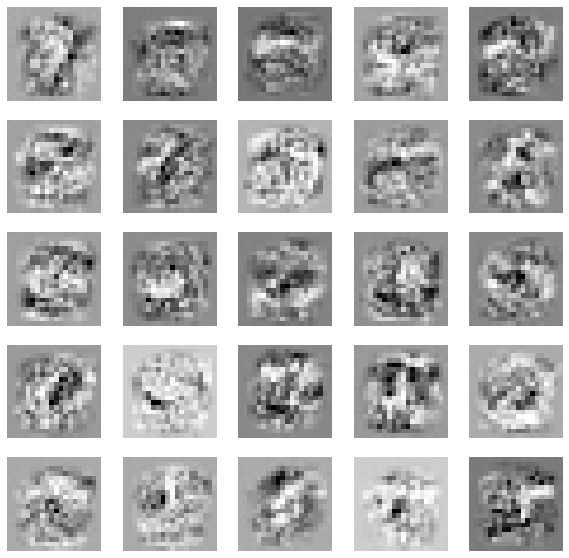

In [10]:
#Reshaping
Theta1_min = theta_unrolled_min.x[:(n_h-1)*(n+1)].reshape(n_h-1,n+1)
dim = int(np.sqrt(n_h - 1))

#Figure
fig, axes = plt.subplots(5,5, figsize=(10,10))
k=0
for i,ax in enumerate(axes.flat):
    ax.axis('off')
    ax.imshow(Theta1_min[k][1:].reshape(int(np.sqrt(n)), int(np.sqrt(n))).T,
                 cmap=plt.get_cmap('Greys'), 
                 interpolation = 'nearest')
    k+=1